In [3]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns 

In [1]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/Our data"

In [ ]:
onlyfiles = [f for f in listdir(my_path) if isfile(join(my_path, f))]
onlyfolds = [f for f in listdir(my_path) if not isfile(join(my_path, f))]
all_files_and_folds = listdir(my_path)

In [ ]:
def renaming_func(some_df):
    col_names = some_df.columns
    for nms in col_names:
        if "Time" in nms:
            some_df = some_df.rename(columns={nms:"time"})
        elif "X " in nms or " x " in nms:
            some_df = some_df.rename(columns={nms:"x"})
        elif "Y " in nms or " y " in nms:
            some_df = some_df.rename(columns={nms:"y"})
        elif "Z " in nms or " z " in nms:
            some_df = some_df.rename(columns={nms:"z"})
        elif "Pressure" in nms:
            some_df = some_df.rename(columns={nms:"pressure"})
        # else:
        #     some_df = some_df.rename(columns={nms:"source_name"})
    return some_df

In [ ]:
acel = "Accelerometer.csv" 
linear_acel = "Linear Accelerometer.csv"
gyro = "Gyroscope.csv"
baro = "Barometer.csv"

file_names = [acel, linear_acel, gyro, baro]
file_names2 = ["Accelerometer.csv", "Linear Acceleration.csv", "Gyroscope.csv", "Pressure.csv"]

In [ ]:
accel_df1 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
lin_accel_df1 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
gyro_df1 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
baro_df1 = pd.DataFrame(columns=["time", "x", "source_name"],dtype=object)

df_list = [accel_df1,lin_accel_df1,gyro_df1,baro_df1]

for i in onlyfolds:
    for count,j in enumerate(file_names):
        my_df = pd.read_csv(my_path+"/"+str(i)+"/"+j)
        my_df["source_name"] = str(i).split()[0]
        my_df = renaming_func(my_df)
        df_list[count] = df_list[count].append(my_df, ignore_index=True)
        #accel_df1 = accel_df1.append(my_df, ignore_index=True)
accel_df1 = df_list[0]
lin_accel_df1 = df_list[1]
gyro_df1 = df_list[2]
baro_df1 = df_list[3]

In [ ]:
# all_gyroscope_df = pd.read_csv(my_path+"/"+"all gyroscope data.csv")

# temp_df = pd.DataFrame(columns=['X (rad/s)_2', 'Y (rad/s)_2', 'Z (rad/s)_2'], dtype = object)

# X_col_ind = [i for i, cols in enumerate(all_gyroscope_df.columns) if "X (rad/s)" in cols]
# Y_col_ind = [i for i, cols in enumerate(all_gyroscope_df.columns) if "Y (rad/s)" in cols]
# Z_col_ind = [i for i, cols in enumerate(all_gyroscope_df.columns) if "Z (rad/s)" in cols]

# def process_gyro_rows(row, temp_df=temp_df):
#     sample_x = np.random.normal(loc=row[X_col_ind].mean(), scale=row[X_col_ind].std(), size=1)
#     sample_y = np.random.normal(loc=row[Y_col_ind].mean(), scale=row[Y_col_ind].std(), size=1)
#     sample_z = np.random.normal(loc=row[Z_col_ind].mean(), scale=row[Z_col_ind].std(), size=1)
#     new_row = [sample_x, sample_y, sample_z]
#     temp_df.loc[len(temp_df)].item = new_row

# for index, rows in all_gyroscope_df.iterrows():
#     process_gyro_rows(row=rows)

# all_gyroscope_df = pd.concat([all_gyroscope_df, temp_df], axis=1)

# all_gyroscope_df = all_gyroscope_df.apply(pd.Series.explode)
# temp_df = temp_df.apply(pd.Series.explode)
# temp_df["Time (s)"] = all_gyroscope_df["Time (s)"]

# temp_df.to_csv('Gyroscope.csv', index=False)

In [ ]:
accel_df2 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
lin_accel_df2 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
gyro_df2 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
baro_df2 = pd.DataFrame(columns=["time", "x", "source_name"],dtype=object)

df_list2 = [accel_df2,lin_accel_df2,gyro_df2,baro_df2]
deicde_list = lambda x: file_names2 if ("FB" in x) else file_names

for i in onlyfiles: #names of zip files
        for count, j in enumerate(deicde_list(i)): #names of csv files
                with zipfile.ZipFile(my_path+"/"+str(i), 'r') as zip_ref: #unzip the zip file
                        with zip_ref.open(j) as file: #take out the csv file
                            my_df = pd.read_csv(file) #have the csv in a df
                            my_df["source_name"] = str(i).split()[0] #add the name of the source 
                            my_df = renaming_func(my_df) #change the names of the columns
                            df_list2[count] = df_list2[count].append(my_df, ignore_index=True) #take out the df and append the data to it

accel_df2 = df_list2[0]
lin_accel_df2 = df_list2[1]
gyro_df2 = df_list2[2]
baro_df2 = df_list2[3]

In [ ]:
accel_df1 = accel_df1.append(accel_df2, ignore_index=True)
lin_accel_df1 = lin_accel_df1.append(lin_accel_df2, ignore_index=True)
gyro_df1 = gyro_df1.append(gyro_df2, ignore_index=True)
baro_df1 = baro_df1.append(baro_df2, ignore_index=True)

In [8]:
# accel_df1.to_csv(my_path+"/"+"all_acceleration.csv", index = False)
# lin_accel_df1.to_csv(my_path+"/"+"all_lin_acceleration.csv", index = False)
# gyro_df1.to_csv(my_path+"/"+"all_gyroscope.csv", index = False)
# baro_df1.to_csv(my_path+"/"+"all_barometer.csv", index = False)

NameError: name 'accel_df1' is not defined

In [4]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/Our data"

accel = pd.read_csv(my_path+"/"+"all_acceleration.csv")
lin_accel = pd.read_csv(my_path+"/"+"all_lin_acceleration.csv")
gyro = pd.read_csv(my_path+"/"+"all_gyroscope.csv")
baro = pd.read_csv(my_path+"/"+"all_barometer.csv")

In [7]:
accel.to_parquet(my_path+"/"+"all_acceleration.parquet.gzip",
              compression='gzip')
lin_accel.to_parquet(my_path+"/"+"all_lin_acceleration.parquet.gzip",
              compression='gzip')
gyro.to_parquet(my_path+"/"+"all_gyroscope.parquet.gzip",
              compression='gzip')
baro.to_parquet(my_path+"/"+"all_barometer.parquet.gzip",
              compression='gzip')

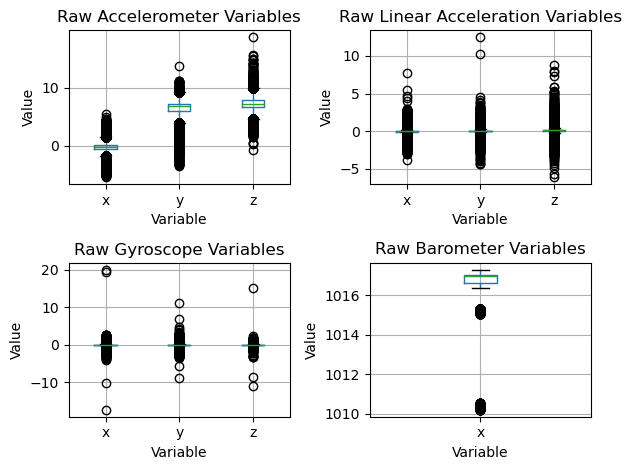

In [38]:
plt.subplot(2, 2, 1)
accel.iloc[:,1:].boxplot()
plt.title('Raw Accelerometer Variables')
plt.suptitle('')  # Suppress the automatic title to keep the plot clean
plt.xlabel('Variable')
plt.ylabel('Value')

plt.subplot(2, 2, 2)
lin_accel.iloc[:,1:].boxplot()
plt.title('Raw Linear Acceleration Variables')
plt.suptitle('')  # Suppress the automatic title to keep the plot clean
plt.xlabel('Variable')
plt.ylabel('Value')

plt.subplot(2, 2, 3)
gyro.iloc[:,1:].boxplot()
plt.title('Raw Gyroscope Variables')
plt.suptitle('')  # Suppress the automatic title to keep the plot clean
plt.xlabel('Variable')
plt.ylabel('Value')

plt.subplot(2, 2, 4)
baro.iloc[:,1:].boxplot()
plt.title('Raw Barometer Variables')
plt.suptitle('')  # Suppress the automatic title to keep the plot clean
plt.xlabel('Variable')
plt.ylabel('Value')

plt.tight_layout()

In [16]:
accel.set_index('time', inplace=True)
baro.set_index('time', inplace=True)
gyro.set_index('time', inplace=True)
lin_accel.set_index('time', inplace=True)

In [28]:
datasets = [accel, baro, gyro, lin_accel]

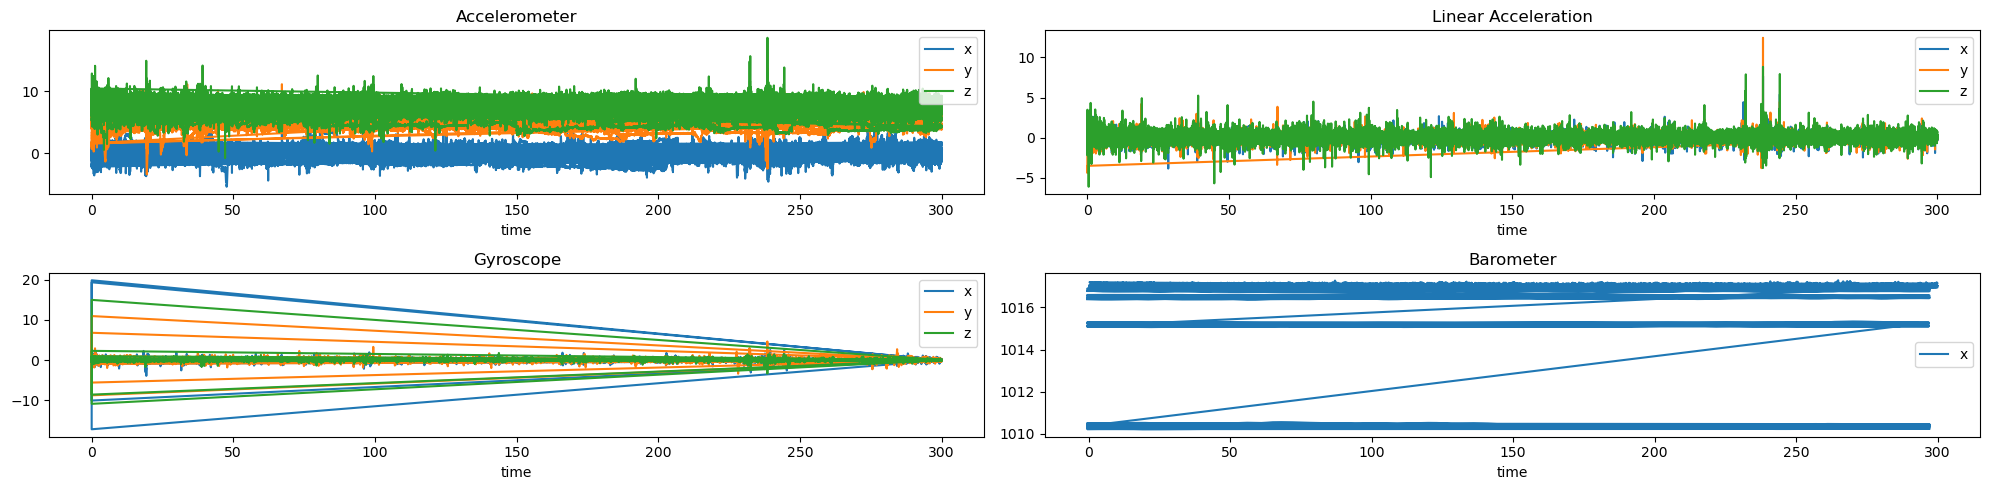

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(20, 5))

accel.plot(ax=axs[0,0])
axs[0,0].set_title('Accelerometer')

lin_accel.plot(ax=axs[0,1])
axs[0,1].set_title('Linear Acceleration')

# Plot dataset3 on the third subplot
gyro.plot(ax=axs[1,0])
axs[1,0].set_title('Gyroscope')

# Plot dataset4 on the fourth subplot
baro.plot(ax=axs[1,1])
axs[1,1].set_title('Barometer')

plt.tight_layout()


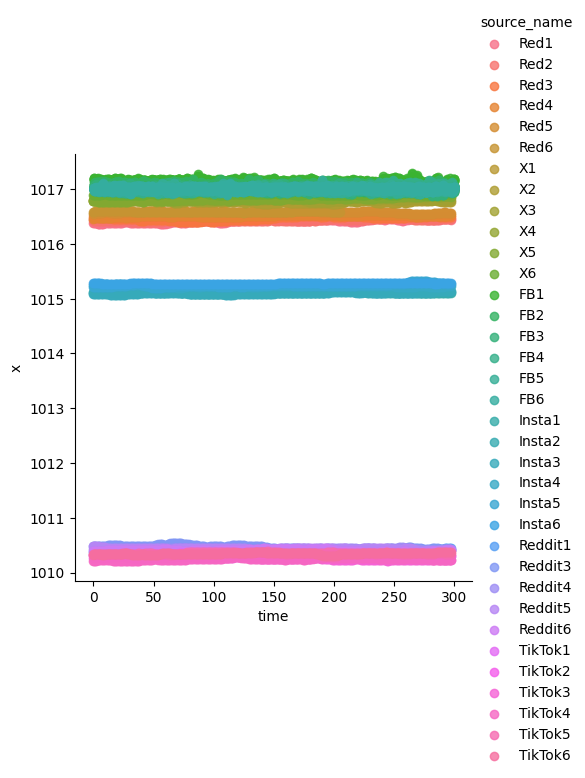

In [9]:
sns.lmplot(x='time', y='x', data=baro, hue='source_name', fit_reg=False)